## Modelo de clasificación

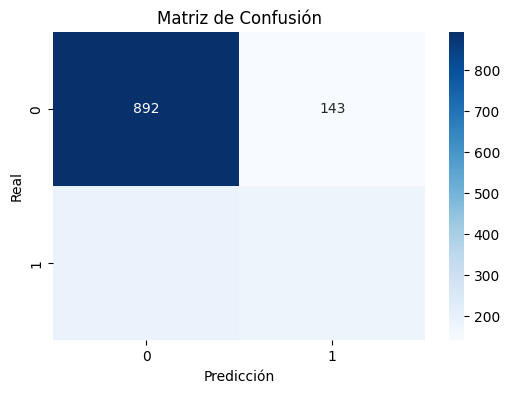

=== Métricas de Clasificación ===

Accuracy: 0.8338

Reporte de Clasificación:
              precision    recall  f1-score   support

       Alpha       0.82      0.86      0.84      1035
       Betha       0.56      0.49      0.52       374

    accuracy                           0.76      1409
   macro avg       0.69      0.68      0.68      1409
weighted avg       0.75      0.76      0.76      1409

Matriz de Confusión:
[[870 165]
 [179 856]]


<Figure size 1000x600 with 0 Axes>

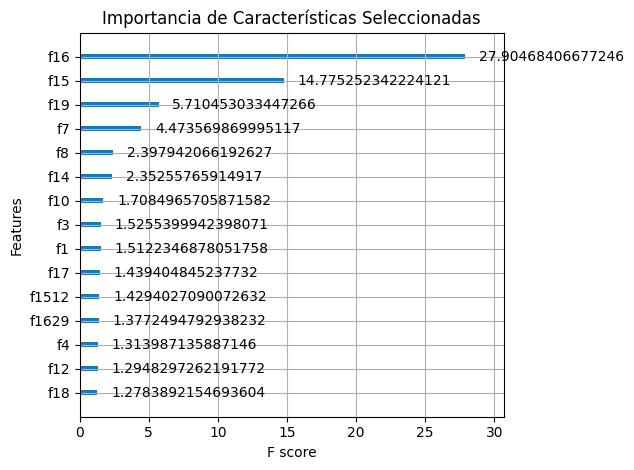

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier, plot_importance
import joblib


df = pd.read_csv("dataset_alpha_betha.csv")


df.drop(columns=["autoID"], inplace=True)


cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
df[cat_cols] = df[cat_cols].astype(str)

df_encoded = pd.get_dummies(df.drop("Class", axis=1), drop_first=True)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["Class"])  

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

model_base = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_base.fit(X_train, y_train)

selector = SelectFromModel(model_base, prefit=True, threshold="median")  
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train_sel, y_train)

joblib.dump(model, "modelo_clasificacion_xgb.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(selector, "selector.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

y_pred = model.predict(X_test_sel)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
cm = confusion_matrix(y_test, y_pred)

with open("metricas_modelo.txt", "w") as f:
    f.write("=== Métricas de Clasificación ===\n\n")
    f.write(f"Accuracy: {accuracy:.4f}\n\n")
    f.write("Reporte de Clasificación:\n")
    f.write(report + "\n")
    f.write("Matriz de Confusión:\n")
    f.write(np.array2string(cm))

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

print("=== Métricas de Clasificación ===\n")
print(f"Accuracy: {acc:.4f}\n")
print("Reporte de Clasificación:")
print(report)
print("Matriz de Confusión:")
print(cm)

plt.figure(figsize=(10, 6))
plot_importance(model, max_num_features=15, importance_type='gain')
plt.title("Importancia de Características Seleccionadas")
plt.tight_layout()
plt.show()


In [10]:
# Mostrar los nombres originales de las variables seleccionadas
selected_feature_names = df_encoded.columns[selector.get_support()]
for i, col in enumerate(selected_feature_names):
    print(f"f{i}: {col}")


f0: SeniorCity
f1: Charges
f2: Partner_Yes
f3: Dependents_Yes
f4: Service1_Yes
f5: Service2_No phone service
f6: Service2_Yes
f7: Security_No internet service
f8: Security_Yes
f9: OnlineBackup_No internet service
f10: OnlineBackup_Yes
f11: DeviceProtection_No internet service
f12: DeviceProtection_Yes
f13: TechSupport_No internet service
f14: TechSupport_Yes
f15: Contract_One year
f16: Contract_Two year
f17: PaperlessBilling_Yes
f18: PaymentMethod_Credit card (automatic)
f19: PaymentMethod_Electronic check
f20: PaymentMethod_Mailed check
f21: Demand_100.2
f22: Demand_100.25
f23: Demand_100.35
f24: Demand_100.4
f25: Demand_100.8
f26: Demand_100.9
f27: Demand_1001.2
f28: Demand_1001.5
f29: Demand_1003.05
f30: Demand_1004.35
f31: Demand_1004.5
f32: Demand_1004.75
f33: Demand_1005.7
f34: Demand_1006.9
f35: Demand_1007.8
f36: Demand_1007.9
f37: Demand_1008.55
f38: Demand_1008.7
f39: Demand_1009.25
f40: Demand_101.1
f41: Demand_101.45
f42: Demand_101.65
f43: Demand_101.9
f44: Demand_1010
f45

In [16]:
df.head(3)

,SeniorCity,Partner,Dependents,Service1,Service2,Security,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,Charges,Demand,Class
0,0,Yes,No,No,No phone service,No,Yes,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,Alpha
1,0,No,No,Yes,No,Yes,No,Yes,No,One year,No,Mailed check,56.95,1889.5,Alpha
2,0,No,No,Yes,No,Yes,Yes,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Betha
